# Start dask

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from dask.distributed import Client
# #Initializing client
# client = Client()
# client



/anaconda3/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Parquet
Used sample: sample_0_prep/full_sample_json.parquet
    * This sample is the 10% sample with the "is_json" column added to it, this column is the result of the 'value' columns as a valid json or not. 
    * This sample can be obtained by running 'jsJson_dataPrep.ipynb'

In [2]:
df = dd.read_parquet('sample_0_prep/full_sample_json.parquet', engine="pyarrow", columns=['value_len', 'is_json'])
df.head(1)

,value_len,is_json
0,8,False


In [3]:
with ProgressBar():
    df = df.compute()

[########################################] | 100% Completed |  1.6s


# Values distribution: 

The absolute majority of the values are small. As seen on the graph below.

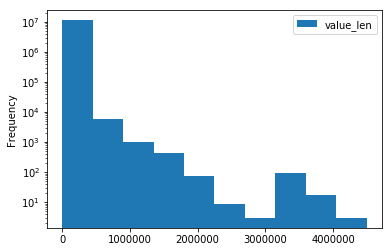

In [4]:
%matplotlib inline
df['value_len'].plot(kind='hist', legend=True, logy=True, bins=10)

# Type distribution
The non-json values are found mainly withing the smaller values.
 - Orange bar: non-json values
 - Blue bars: json values

Text(0, 0.5, 'density')

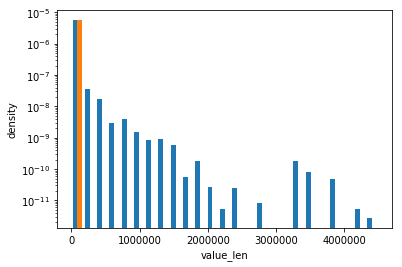

In [5]:
plt.hist(
    (df[df.is_json==True].value_len, df[df.is_json==False].value_len),
    bins=25,
    density=True,
    label=['true', 'false'],
#     color=['teal','orange'],
)
plt.yscale('log')
plt.xlabel('value_len')
plt.ylabel('density')

Text(0, 0.5, 'density')

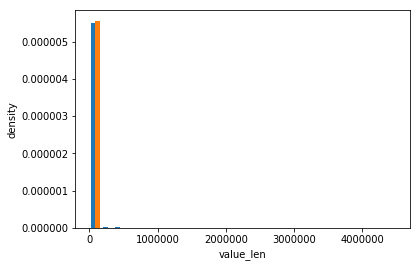

In [6]:
plt.hist(
    (df[df.is_json==True].value_len, df[df.is_json==False].value_len),
    bins=25,
    density=True,
    label=['true', 'false'],
#     color=['teal','orange'],
)
plt.xlabel('value_len')
plt.ylabel('density')

# JSON percentual by group
Here the orange is the percentual of non-JSON values found in each group, and the blue is the percentual of JSON values. 
We can see that as we filter the data to bigger values the percentual of JSON values also increases. 

The gorups are: 
- Original: all original data (sample 10%)
- Above_mean: original data filtered to only values above the mean
- Above_std: original data filtered to only values 1 std above the mean

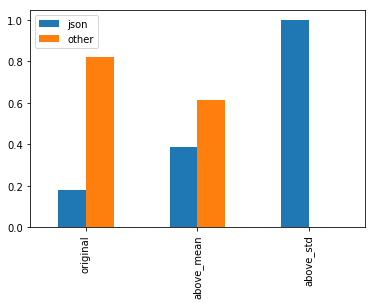

In [7]:
def count_json(df):
    trues = df.is_json[df.is_json == True].count()
    falses = df.is_json[df.is_json == False].count()
    total = df.is_json.count()
    return trues/total, falses/total
    
total_count = count_json(df)
total_mean = df.value_len.mean()
total_std = df.value_len.std()

above_mean_count = count_json(df[df['value_len'] > total_mean])
above_std_count = count_json(df[df['value_len'] > (total_mean + total_std)])

p1 = pd.DataFrame([total_count, above_mean_count, above_std_count],
                  columns= [ 'json', 'other'],
                 index=[ 'original', 'above_mean', 'above_std'])
plot = p1.plot(kind='bar')

# JSON percentual by bins

In [8]:
#Helper code to separate and calculate what needed
import math
def percetangeData(df):
    bins=[]
    trues=[]
    falses=[]
    
    nbins = 10
    minimum_value = min(df.value_len)
    range_value = max(df.value_len) - minimum_value
    step = math.ceil(range_value/nbins)
    bin_max_range = minimum_value
    def count_in_range(df):
        f1 = df.value_len >= bin_max_range - step
        f2 = df.value_len < bin_max_range
        return len(df[f1 & f2])

    for x in range(0, nbins):
        bin_max_range += step
        range_count = count_in_range(df)
        bins.append(str(bin_max_range)) #superior margin for each bin
        if range_count == 0:
            #If range_count is 0 then there is no counting to do for trues or falses, all 0. 
            trues.append(0)
            falses.append(0)
        else:
            trues.append(count_in_range(df[df.is_json == True]) / range_count)
            falses.append(count_in_range(df[df.is_json == False]) / range_count)

#     print('Bins:', bins)
#     print('Trues: ', trues)
#     print('Falses: ', falses)
#     print(pd.DataFrame([bins, trues, falses], index= ['up to value', 'json%', 'non json%']))
    return (bins, trues, falses)

def plotPercentualComparison(df, title='Value type: Json X Other'):
    bins, trues, falses = percetangeData(df)
    width = 0.95
    p1 = plt.bar(bins, trues, width=width)
    p2 = plt.bar(bins, falses, bottom=trues, width=width)

    plt.ylabel('Scores')
    plt.xlabel('Value_len')
    plt.title(title)
    plt.legend((p1[0], p2[0]), ('JSON', 'Other'))
    idx = np.round(np.linspace(0, 10 - 1, 4)).astype(int)
    plt.xticks(idx, [bins[i] for i in idx])

    return plt

## All values
If all data is divided in 10 bins and the percentage of NON-JSON values in each bin is painted orange, we have the following graph:

<module 'matplotlib.pyplot' from '/anaconda3/envs/overscripted/lib/python3.6/site-packages/matplotlib/pyplot.py'>

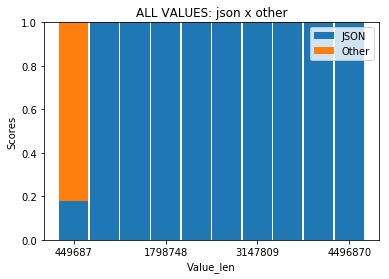

In [9]:
plotPercentualComparison(df, title='ALL VALUES: json x other')

This graph proves that all bigger values are JSON and the non-json types only appear on the smaller values.

# Conclusion

There is absolute no value greater than 104653 (max value for non-json) that represents a valid JSON in this 10% sample. 

This implies that all the greater values are JSON but they represent very low percentage of the whole data (6.76%).  

In [10]:
max_non_json_value_len = df[df.is_json == False].value_len.max()
allJson = df[df['value_len'] > max_non_json_value_len ]
length = allJson.is_json.count()
print("The top ({0:0.2f}% - whole sample) / ({1:0.2f}% - values above the mean) is guarantee to be a valid JSON".format(
    length / df.is_json.count() * 100, length / df[df.value_len > df.value_len.mean()].is_json.count() * 100))

The top (0.30% - whole sample) / (6.76% - values above the mean) is guarantee to be a valid JSON


--- 

# Out of Curiosity: small values
This is not exactly relevant to the issue 22 ('What's in the really large values?') but I was curious to know how was the distribution of the smaller values

## Distribution of non-json values
That concentration of the non-json values made me curious: how is the distribution of NON-JSON values among the smaller values? 
To answer this I filtered the data to only values bellow the bigger non-json and ploted the same graph.
- What I got is, again, the absolute majority of these non-json are on the first bin, so they really tend to be small values.  
     
     *TODO: what is that really small portion of non-json values present on the 9th bin? Are they any different from the others thre are smaller?

Bigger non json value_len:  104653


<module 'matplotlib.pyplot' from '/anaconda3/envs/overscripted/lib/python3.6/site-packages/matplotlib/pyplot.py'>

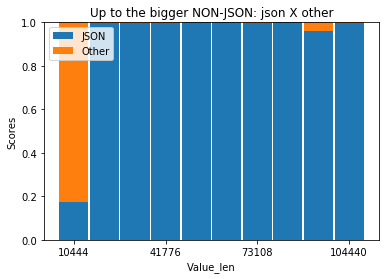

In [11]:
print("Bigger non json value_len: ", max_non_json_value_len)
plotPercentualComparison(df[df.value_len < (max_non_json_value_len)], title="Up to the bigger NON-JSON: json X other")

Still, what about that first bin (the fist 1/10th)?

first 1/10th:  10465.3


<module 'matplotlib.pyplot' from '/anaconda3/envs/overscripted/lib/python3.6/site-packages/matplotlib/pyplot.py'>

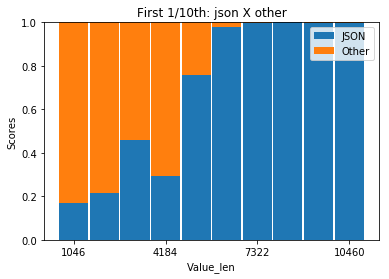

In [12]:
print("first 1/10th: ", max_non_json_value_len/10)
plotPercentualComparison(df[df.value_len < (max_non_json_value_len/10)], title="First 1/10th: json X other")

### Distribution for the values bellow the mean
This is where 95% of the rows are, they do have JSON types on them but as we can see, most of this data is of some other type, not json, and they have a eavenly distribution of this value_range, why is that?

The values smaller than the mean represent 95.57% of the whole sample


<module 'matplotlib.pyplot' from '/anaconda3/envs/overscripted/lib/python3.6/site-packages/matplotlib/pyplot.py'>

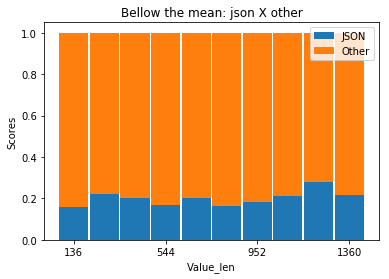

In [13]:
m = df.value_len.mean()
bellow_mean = df[df.value_len <= (m)]
print('The values smaller than the mean represent {0:0.2f}% of the whole sample'.format(bellow_mean.is_json.count()/df.is_json.count()*100))
plotPercentualComparison(bellow_mean, title='Bellow the mean: json X other')

There is more JSON values below the mean than above the mean, but that's not surprising since the data below the mean is 95% of everything.

In [14]:
bellow_mean_count = bellow_mean[bellow_mean.is_json == True].is_json.count()
above_mean_count = df[(df.value_len > m) & (df.is_json == True)].is_json.count()
total = bellow_mean_count + above_mean_count
print("Jsons below the mean are {0:.2f}% of all jsons".format(bellow_mean_count/total * 100))

Jsons below the mean are 90.48% of all jsons
